In [1]:
import hydra
import pandas as pd
import pickle
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from data_lake.constants import (
    DB_ADDRESS,
    DEFAULT_RESAMPLED_SPACING,
    TARGET_COLLECTION_FEATURE,
    TARGET_DB,
)
from shared_lib.radiomics import RadiomicsFeatureKeys

In [2]:
_LUNG_DB = DB_ADDRESS
_CLIENT = pymongo.MongoClient(_LUNG_DB)

In [3]:
# set projection
projection = {}

# set query
query = {}

# get list of 'data_source'
docs = [x for x in _CLIENT[TARGET_DB][TARGET_COLLECTION_FEATURE].find(query, projection)]
print(len(docs))
df = pd.DataFrame(docs)

6163


In [4]:
df.keys()

Index(['_id', 'patient_id', 'series_instance_uid', 'annotation_id',
       'studydate', 'h5_path_nfs', 'h5_path', 'fold', 'label', 'age_at_study',
       'gender', 'origin', 'transform', 'spacing', 'resampled_spacing',
       'w_coord_zyx', 'd_coord_zyx', 'r_coord_zyx',
       'pred_c_calcification_logistic', 'pred_c_internalStructure_logistic',
       'pred_c_lobulation_logistic', 'pred_c_malignancy_logistic',
       'pred_c_margin_logistic', 'pred_c_sphericity_logistic',
       'pred_c_spiculation_logistic', 'pred_c_subtlety_logistic',
       'pred_c_texture_logistic', 'pred_original_firstorder_Energy',
       'pred_original_firstorder_Entropy', 'pred_original_firstorder_Kurtosis',
       'pred_original_firstorder_Mean', 'pred_original_firstorder_Median',
       'pred_original_firstorder_Skewness',
       'pred_original_firstorder_TotalEnergy',
       'pred_original_firstorder_Uniformity',
       'pred_original_glcm_ClusterShade', 'pred_original_glcm_ClusterTendency',
       'pred_or

## Nodule attributions

In [5]:
target_attr_total = [ 'c_subtlety_logistic', 'c_sphericity_logistic', 'c_lobulation_logistic', 'c_spiculation_logistic',
                     'c_margin_logistic', 'c_texture_logistic',
                     'c_calcification_logistic', 'c_internalStructure_logistic', 'c_malignancy_logistic' ]

target_attr_total = [f"pred_{attr}" for attr in target_attr_total]

In [6]:
target_attr_total

['pred_c_subtlety_logistic',
 'pred_c_sphericity_logistic',
 'pred_c_lobulation_logistic',
 'pred_c_spiculation_logistic',
 'pred_c_margin_logistic',
 'pred_c_texture_logistic',
 'pred_c_calcification_logistic',
 'pred_c_internalStructure_logistic',
 'pred_c_malignancy_logistic']

In [7]:
df[target_attr_total].describe()

,pred_c_subtlety_logistic,pred_c_sphericity_logistic,pred_c_lobulation_logistic,pred_c_spiculation_logistic,pred_c_margin_logistic,pred_c_texture_logistic,pred_c_calcification_logistic,pred_c_internalStructure_logistic,pred_c_malignancy_logistic
count,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000
mean,0.587073,0.563330,0.355024,0.325872,0.586648,0.670000,0.246281,0.218569,0.486410
std,0.060188,0.013980,0.046392,0.056632,0.052805,0.080737,0.103942,0.052695,0.053646
min,0.455388,0.513454,0.265551,0.209104,0.425186,0.381805,0.071287,0.088308,0.306268
25%,0.546523,0.554186,0.321954,0.284977,0.552021,0.620142,0.175609,0.180123,0.452784
50%,0.575209,0.564758,0.343880,0.311208,0.591233,0.677929,0.227046,0.204936,0.473317
75%,0.614360,0.573143,0.378826,0.353054,0.624810,0.726602,0.292398,0.246045,0.509860
max,0.847425,0.612986,0.548327,0.567480,0.767461,0.898230,0.833422,0.411836,0.724775


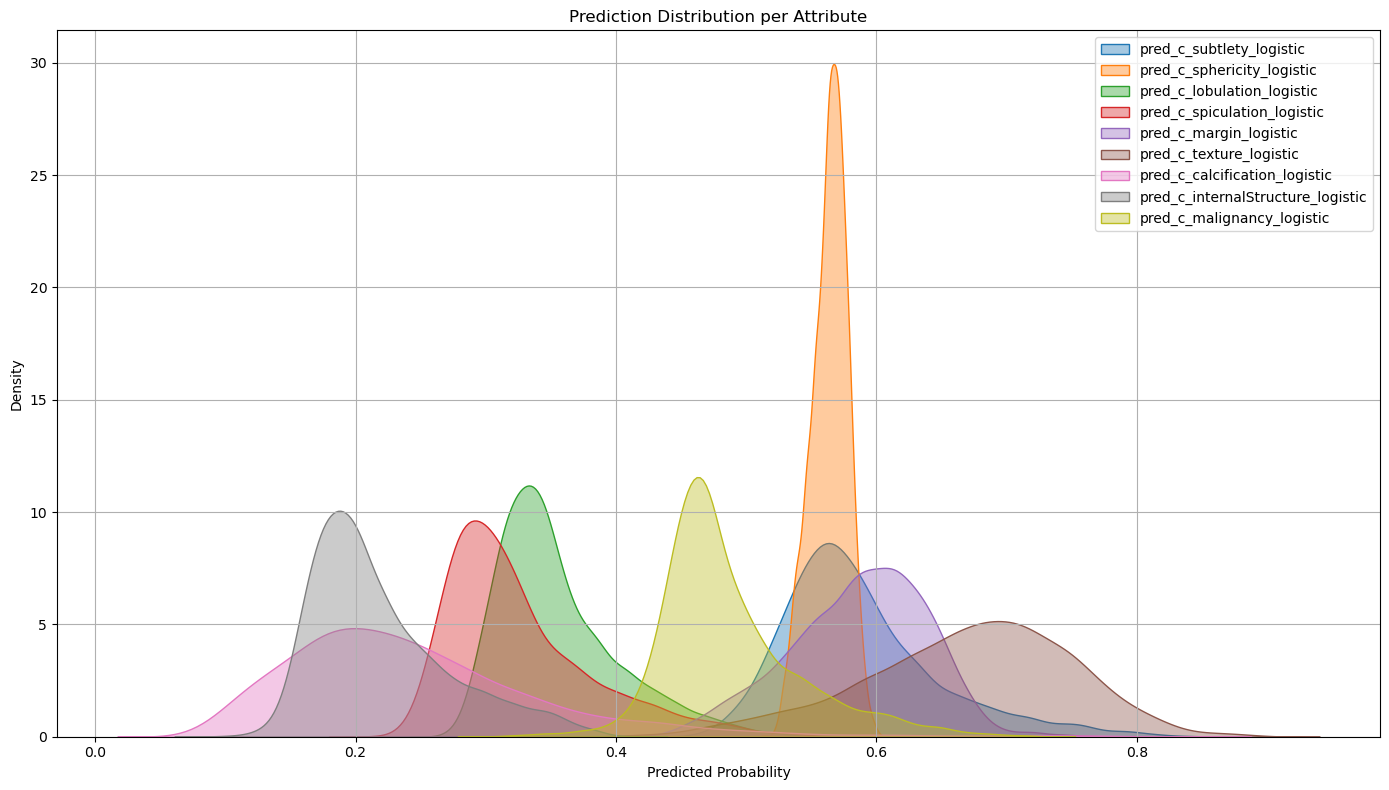

In [8]:
plt.figure(figsize=(14, 8))
for col in target_attr_total:
    sns.kdeplot(df[col], label=col, fill=True, common_norm=False, alpha=0.4)

plt.title("Prediction Distribution per Attribute")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

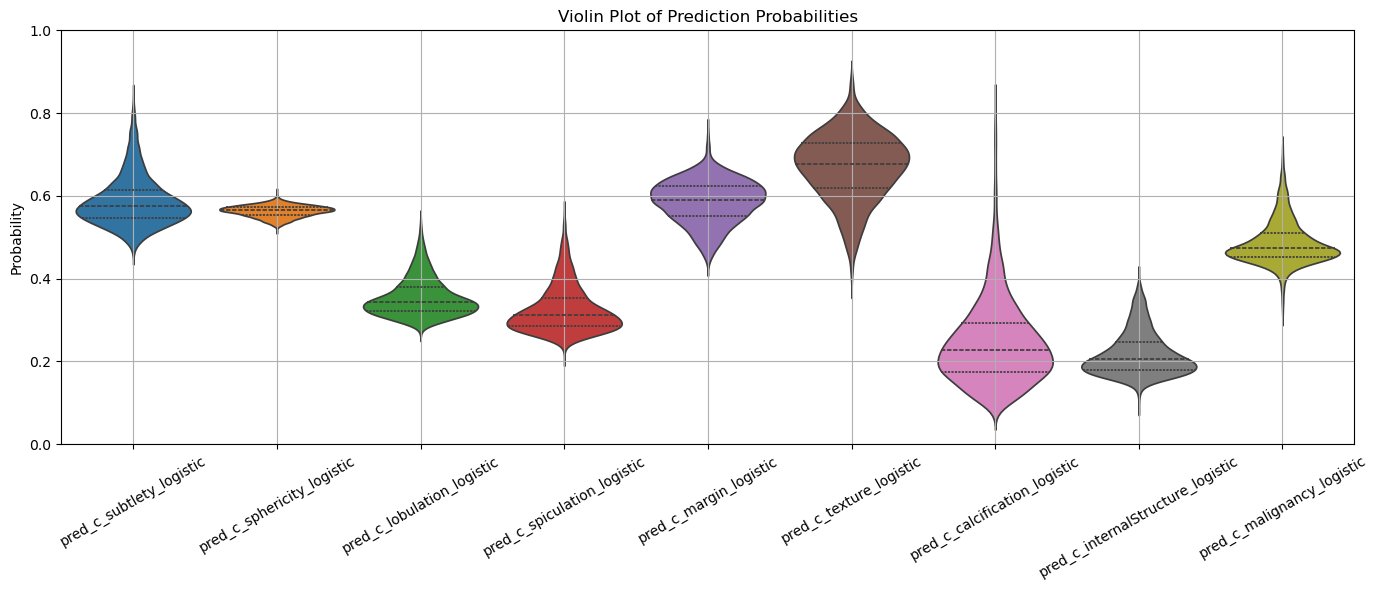

In [9]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=df[target_attr_total], inner="quart")
plt.xticks(rotation=30)
plt.title("Violin Plot of Prediction Probabilities")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

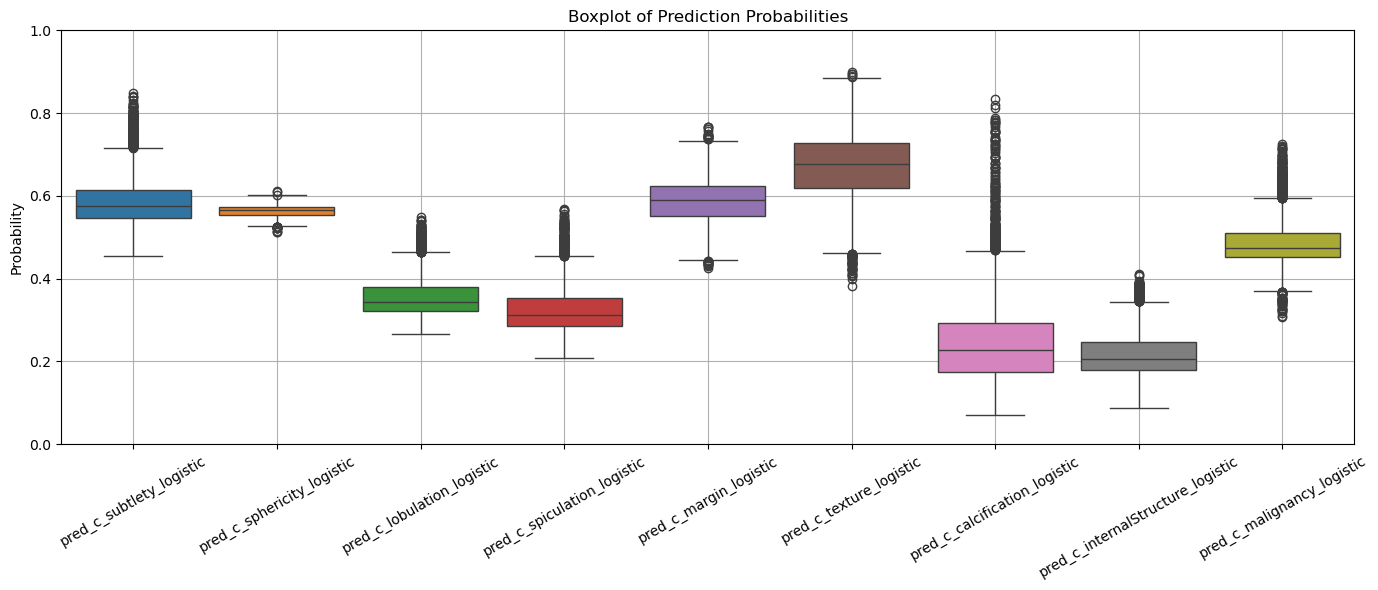

In [10]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[target_attr_total])
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.title("Boxplot of Prediction Probabilities")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

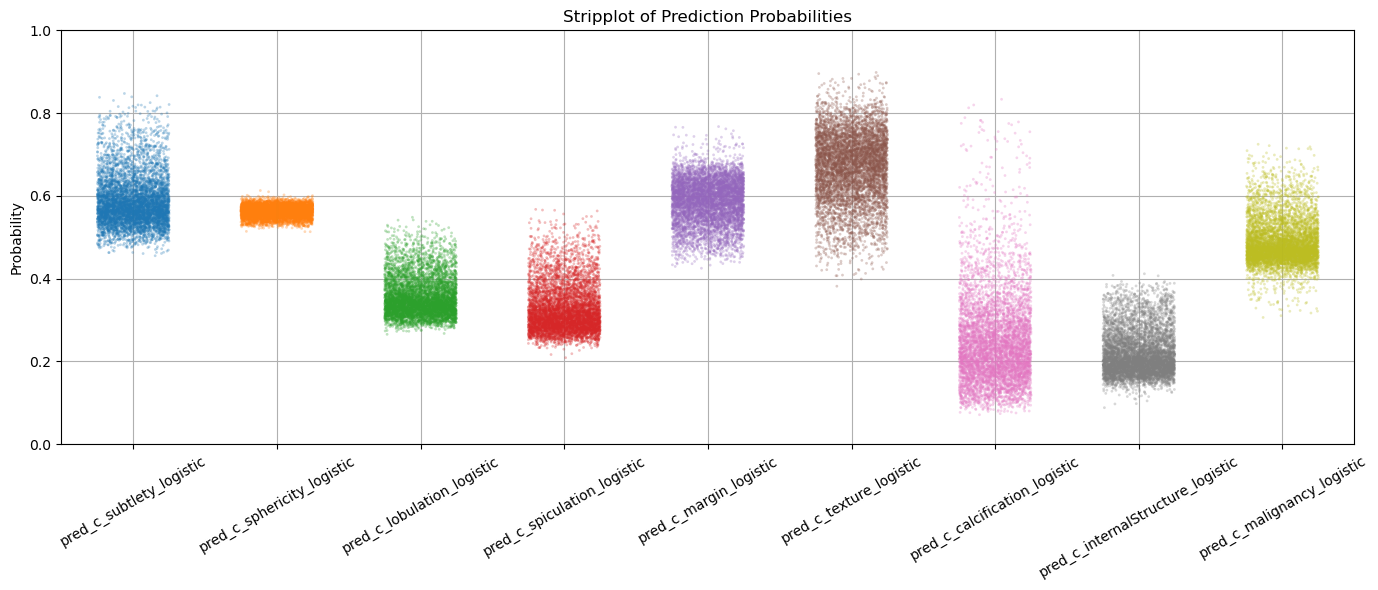

In [11]:
plt.figure(figsize=(14, 6))
sns.stripplot(data=df[target_attr_total], jitter=0.25, size=2, alpha=0.3)
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.title("Stripplot of Prediction Probabilities")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

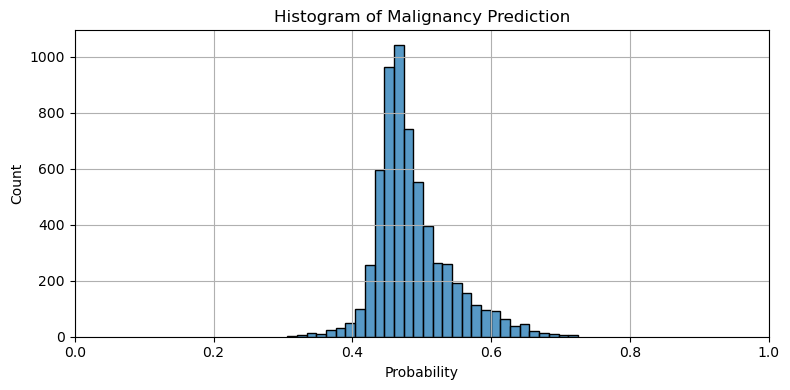

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(df["pred_c_malignancy_logistic"], bins=30, kde=False)
plt.title("Histogram of Malignancy Prediction")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.xlim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

## radiomcs

In [13]:
features = RadiomicsFeatureKeys()

In [14]:
col_radiomics = []
for group_name in features.__dataclass_fields__:
    group_keys = getattr(features, group_name)
    for group_key in group_keys:
        col_radiomics.append(f"pred_{group_key}")

In [15]:
df[col_radiomics].describe()

,pred_original_shape_Sphericity,pred_original_shape_Elongation,pred_original_shape_SurfaceVolumeRatio,pred_original_shape_MeshVolume,pred_original_shape_MajorAxisLength,pred_original_shape_MinorAxisLength,pred_original_shape_Flatness,pred_original_shape_Maximum3DDiameter,pred_original_shape_VoxelVolume,pred_original_firstorder_Entropy,...,pred_original_glrlm_RunLengthNonUniformity,pred_original_glrlm_LongRunHighGrayLevelEmphasis,pred_original_glszm_SmallAreaEmphasis,pred_original_glszm_LargeAreaEmphasis,pred_original_glszm_GrayLevelNonUniformity,pred_original_glszm_ZoneEntropy,pred_original_gldm_SmallDependenceEmphasis,pred_original_gldm_LargeDependenceEmphasis,pred_original_gldm_DependenceNonUniformity,pred_original_gldm_DependenceEntropy
count,6163.000000,6.163000e+03,6163.000000,6163.000000,6163.000000,6.163000e+03,6163.000000,6163.000000,6163.000000,6.163000e+03,...,6163.000000,6163.000000,6.163000e+03,6.163000e+03,6163.000000,6.163000e+03,6163.000000,6163.000000,6163.000000,6.163000e+03
mean,0.800726,7.191056e-01,1.156621,505.946285,11.762067,7.212091e+00,0.566557,12.835855,511.994304,-3.203427e-16,...,25.578754,29.416060,4.499324e-03,7.820341e+06,1.161123,1.458038e-01,0.003637,418.905811,314.591217,3.766820e+00
std,0.085645,1.911000e-01,0.433079,1234.239852,9.519898,4.118862e+00,0.175146,8.536338,1237.785131,9.861561e-32,...,17.701879,34.210354,4.212446e-02,5.714397e+07,0.473752,3.920526e-01,0.003874,86.877391,1204.008557,4.330444e-01
min,0.398902,7.863218e-09,0.255520,0.149633,1.547299,1.490116e-08,0.000000,1.498166,0.897800,-3.203427e-16,...,1.000000,1.894863,5.247253e-10,4.000000e+00,1.000000,-3.203427e-16,0.001738,4.000000,2.000000,-3.203427e-16
25%,0.753563,6.451561e-01,0.889784,69.046431,6.009063,4.608790e+00,0.479304,7.028584,72.272900,-3.203427e-16,...,14.223494,12.194158,2.932070e-06,2.365483e+04,1.000000,-3.203427e-16,0.002861,355.448704,11.130051,3.650882e+00
50%,0.832113,7.643216e-01,1.200013,123.129529,7.751692,5.630388e+00,0.597399,9.077714,127.487600,-3.203427e-16,...,19.061997,16.817185,1.876692e-05,6.760000e+04,1.000000,-3.203427e-16,0.003521,403.098701,21.863768,3.926004e+00
75%,0.864841,8.520905e-01,1.413169,353.452637,13.471703,8.229741e+00,0.688607,15.725550,361.140050,-3.203427e-16,...,30.421241,30.515367,5.250998e-05,5.241760e+05,1.000000,-3.203427e-16,0.004051,477.804441,95.777826,4.043452e+00
max,0.919649,9.931570e-01,17.517494,19571.160904,81.233824,3.779944e+01,0.938499,63.448531,19596.729500,-3.203427e-16,...,158.857682,381.129448,6.666667e-01,1.905759e+09,8.000000,3.000000e+00,0.250000,653.430155,24194.432688,4.392836e+00


In [16]:
# 평균, 표준편차 계산
means = df[col_radiomics].mean()
stds = df[col_radiomics].std()

In [17]:
# 저장
with open("radiomics_stats.pkl", "wb") as f:
    pickle.dump({"mean": means, "std": stds}, f)

# 불러오기
with open("radiomics_stats.pkl", "rb") as f:
    stats = pickle.load(f)

_means = stats["mean"]
_stds = stats["std"]

In [18]:
# 정규화
df[col_radiomics] = (df[col_radiomics] - means) / stds
print(means)
print(stds)

pred_original_shape_Sphericity                      8.007263e-01
pred_original_shape_Elongation                      7.191056e-01
pred_original_shape_SurfaceVolumeRatio              1.156621e+00
pred_original_shape_MeshVolume                      5.059463e+02
pred_original_shape_MajorAxisLength                 1.176207e+01
pred_original_shape_MinorAxisLength                 7.212091e+00
pred_original_shape_Flatness                        5.665565e-01
pred_original_shape_Maximum3DDiameter               1.283586e+01
pred_original_shape_VoxelVolume                     5.119943e+02
pred_original_firstorder_Entropy                   -3.203427e-16
pred_original_firstorder_Skewness                   7.201409e-02
pred_original_firstorder_Kurtosis                   2.393786e+00
pred_original_firstorder_Mean                       4.861578e-01
pred_original_firstorder_Median                     4.853166e-01
pred_original_firstorder_Energy                     4.012107e+02
pred_original_firstorder_

In [19]:
nan_columns = df[col_radiomics].columns[df[col_radiomics].isna().any()].tolist()
print(nan_columns)

[]


In [20]:
df[col_radiomics].describe()

,pred_original_shape_Sphericity,pred_original_shape_Elongation,pred_original_shape_SurfaceVolumeRatio,pred_original_shape_MeshVolume,pred_original_shape_MajorAxisLength,pred_original_shape_MinorAxisLength,pred_original_shape_Flatness,pred_original_shape_Maximum3DDiameter,pred_original_shape_VoxelVolume,pred_original_firstorder_Entropy,...,pred_original_glrlm_RunLengthNonUniformity,pred_original_glrlm_LongRunHighGrayLevelEmphasis,pred_original_glszm_SmallAreaEmphasis,pred_original_glszm_LargeAreaEmphasis,pred_original_glszm_GrayLevelNonUniformity,pred_original_glszm_ZoneEntropy,pred_original_gldm_SmallDependenceEmphasis,pred_original_gldm_LargeDependenceEmphasis,pred_original_gldm_DependenceNonUniformity,pred_original_gldm_DependenceEntropy
count,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,...,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03,6.163000e+03
mean,-7.090439e-16,4.306145e-16,8.992752e-17,3.458751e-17,-7.148085e-17,1.475734e-16,-1.945547e-16,-1.913842e-16,9.799794e-18,9.999189e-01,...,2.651709e-17,3.458751e-17,-1.210563e-17,-2.305834e-18,-4.496376e-17,1.037625e-17,3.516397e-17,-4.519435e-16,1.095271e-17,-4.012151e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.110313e-16,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.691729e+00,-3.762981e+00,-2.080685e+00,-4.098042e-01,-1.072991e+00,-1.750991e+00,-3.234767e+00,-1.328168e+00,-4.129121e-01,9.999189e-01,...,-1.388483e+00,-8.044698e-01,-1.068102e-01,-1.368532e-01,-3.400995e-01,-3.718985e-01,-4.902559e-01,-4.775763e+00,-2.596254e-01,-8.698463e+00
25%,-5.506822e-01,-3.869677e-01,-6.161394e-01,-3.539829e-01,-6.043136e-01,-6.320438e-01,-4.981725e-01,-6.803000e-01,-3.552486e-01,9.999189e-01,...,-6.414720e-01,-5.034120e-01,-1.067406e-01,-1.364393e-01,-3.400995e-01,-3.718985e-01,-2.001695e-01,-7.304214e-01,-2.520424e-01,-2.677275e-01
50%,3.664789e-01,2.366091e-01,1.001964e-01,-3.101640e-01,-4.212624e-01,-3.840147e-01,1.760942e-01,-4.402521e-01,-3.106409e-01,9.999189e-01,...,-3.681393e-01,-3.682767e-01,-1.063647e-01,-1.356703e-01,-3.400995e-01,-3.718985e-01,-2.982294e-02,-1.819473e-01,-2.431274e-01,3.675914e-01
75%,7.486098e-01,6.958914e-01,5.923832e-01,-1.235527e-01,1.795856e-01,2.470707e-01,6.968519e-01,3.385169e-01,-1.218743e-01,9.999189e-01,...,2.735578e-01,3.213373e-02,-1.055637e-01,-1.276804e-01,-3.400995e-01,-3.718985e-01,1.070327e-01,6.779512e-01,-1.817374e-01,6.388075e-01
max,1.388554e+00,1.434073e+00,3.777807e+01,1.544693e+01,7.297532e+00,7.426164e+00,2.123612e+00,5.929085e+00,1.541846e+01,9.999189e-01,...,7.529084e+00,1.028090e+01,1.571931e+01,3.321328e+01,1.443556e+01,7.280137e+00,6.359949e+01,2.699487e+00,1.983361e+01,1.445616e+00


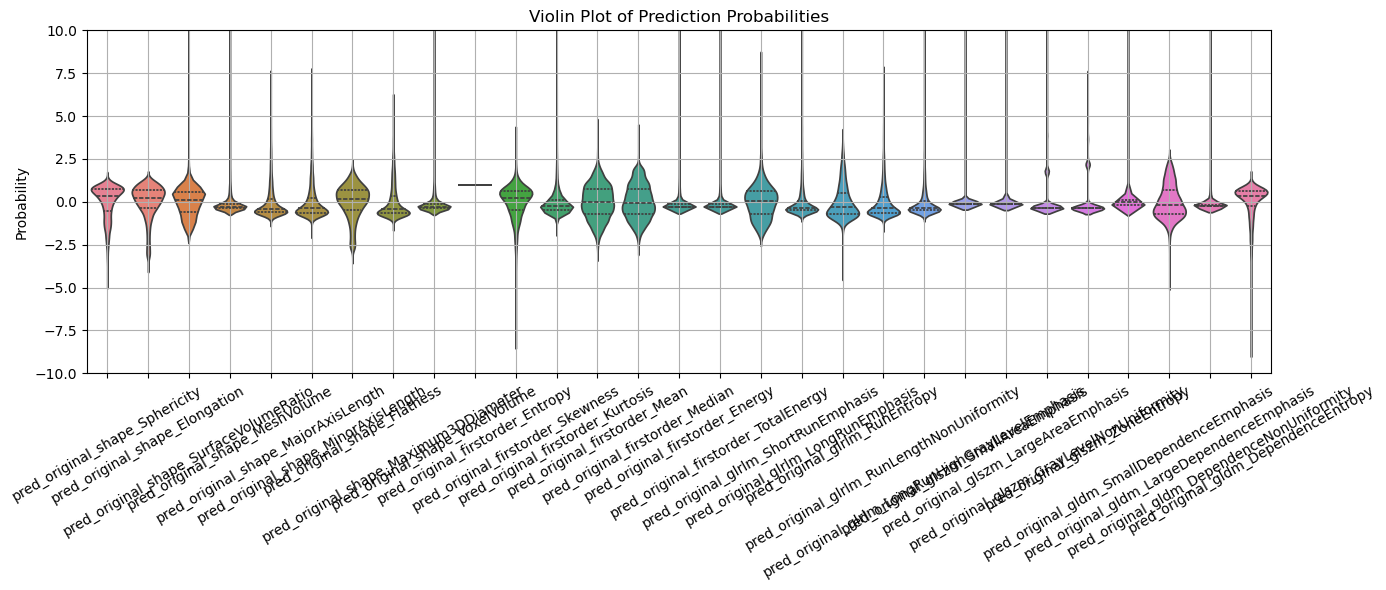

In [21]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=df[col_radiomics], inner="quart")
plt.xticks(rotation=30)
plt.title("Violin Plot of Prediction Probabilities")
plt.ylabel("Probability")
plt.ylim(-10, 10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
df[col_radiomics].columns

Index(['pred_original_shape_Sphericity', 'pred_original_shape_Elongation',
       'pred_original_shape_SurfaceVolumeRatio',
       'pred_original_shape_MeshVolume', 'pred_original_shape_MajorAxisLength',
       'pred_original_shape_MinorAxisLength', 'pred_original_shape_Flatness',
       'pred_original_shape_Maximum3DDiameter',
       'pred_original_shape_VoxelVolume', 'pred_original_firstorder_Entropy',
       'pred_original_firstorder_Skewness',
       'pred_original_firstorder_Kurtosis', 'pred_original_firstorder_Mean',
       'pred_original_firstorder_Median', 'pred_original_firstorder_Energy',
       'pred_original_firstorder_TotalEnergy',
       'pred_original_glrlm_ShortRunEmphasis',
       'pred_original_glrlm_LongRunEmphasis', 'pred_original_glrlm_RunEntropy',
       'pred_original_glrlm_RunLengthNonUniformity',
       'pred_original_glrlm_LongRunHighGrayLevelEmphasis',
       'pred_original_glszm_SmallAreaEmphasis',
       'pred_original_glszm_LargeAreaEmphasis',
       'pred

In [23]:
df["label"]

0       0
1       0
2       0
3       0
4       0
       ..
6158    0
6159    0
6160    0
6161    0
6162    0
Name: label, Length: 6163, dtype: int64

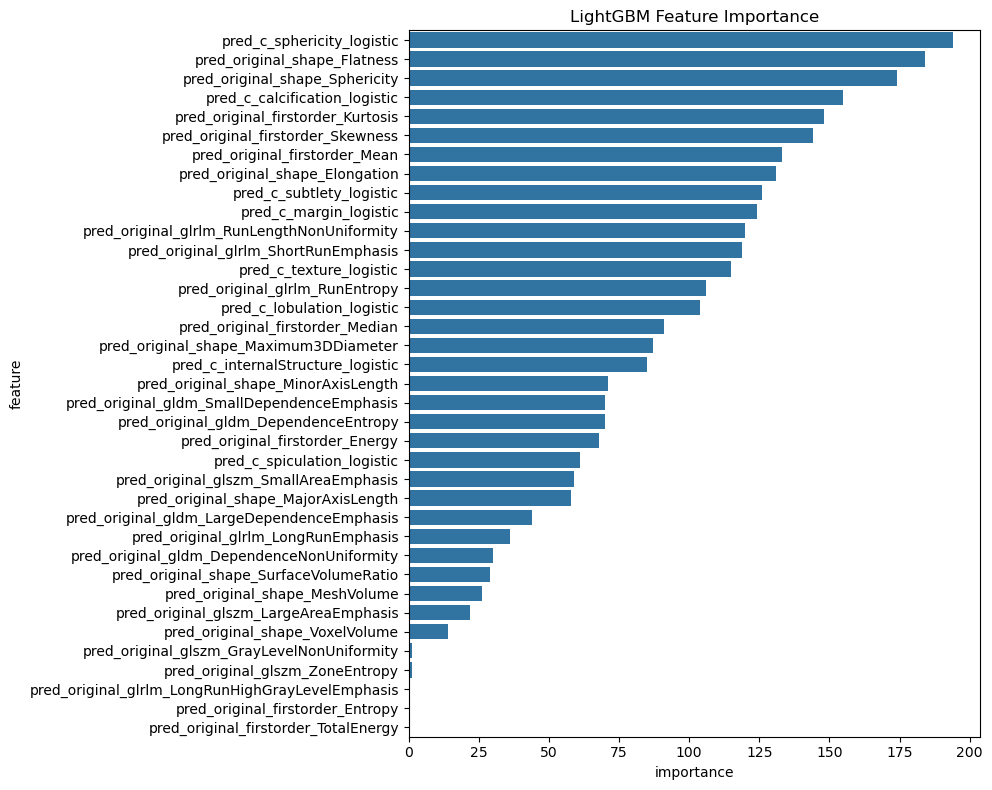

In [24]:
# target feature 정의
if "pred_c_malignancy_logistic" in target_attr_total:
    target_attr_total.remove("pred_c_malignancy_logistic")
feature_col = col_radiomics + target_attr_total

# X, y 정의
X = df[feature_col]
y = df["label"]

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 학습
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)
params = {"objective": "binary", "metric": "auc", "verbosity": -1}
model = lgb.train(params, train_data, valid_sets=[val_data])

# 중요도 시각화
feature_imp = pd.DataFrame({
    "feature": feature_col,
    "importance": model.feature_importance()
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_imp, x="importance", y="feature")
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

In [27]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LightGBM_1": LGBMClassifier(n_estimators=50, learning_rate=0.1),
    "LightGBM_2": LGBMClassifier(n_estimators=50, learning_rate=0.03),
    "LightGBM_3": LGBMClassifier(n_estimators=100, learning_rate=0.03),
    "LightGBM_4": LGBMClassifier(n_estimators=50, learning_rate=0.01),
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring="roc_auc", cv=5)
    print(f"{name}: AUC {scores.mean():.4f} ± {scores.std():.4f}")

Random Forest: AUC 0.8484 ± 0.0155
Logistic Regression: AUC 0.8554 ± 0.0084
LightGBM_1: AUC 0.8539 ± 0.0150
LightGBM_2: AUC 0.8489 ± 0.0135
LightGBM_3: AUC 0.8542 ± 0.0141
LightGBM_4: AUC 0.8406 ± 0.0148
